In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# ------------------------------------
# file: zca.py
# date: Thu May 21 15:47 2015
# author:
# Maarten Versteegh
# github.com/mwv
# maartenversteegh AT gmail DOT com
#
# Licensed under GPLv3
# ------------------------------------
"""zca: ZCA whitening with a sklearn-like interface

"""

from __future__ import division

import numpy as np
from scipy import linalg
import tensorflow as tf
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.utils.validation import check_is_fitted
from sklearn.utils import check_array, as_float_array
# Step 1: Import the relevant libraries and load the data into the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class ZCA(BaseEstimator, TransformerMixin):
    def __init__(self, regularization=1e-6, copy=False):
        self.regularization = regularization
        self.copy = copy

    def fit(self, X, y=None):
        """Compute the mean, whitening and dewhitening matrices.

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data used to compute the mean, whitening and dewhitening
            matrices.
        """
        X = check_array(X, accept_sparse=None, copy=self.copy,
                        ensure_2d=True)
        X = as_float_array(X, copy=self.copy)
        self.mean_ = X.mean(axis=0)
        X_ = X - self.mean_
        cov = np.dot(X_.T, X_) / (X_.shape[0]-1)
        U, S, _ = linalg.svd(cov)
        s = np.sqrt(S.clip(self.regularization))
        s_inv = np.diag(1./s)
        s = np.diag(s)
        self.whiten_ = np.dot(np.dot(U, s_inv), U.T)
        self.dewhiten_ = np.dot(np.dot(U, s), U.T)
        return self

    def transform(self, X, y=None, copy=None):
        """Perform ZCA whitening

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to whiten along the features axis.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X - self.mean_, self.whiten_.T)

    def inverse_transform(self, X, copy=None):
        """Undo the ZCA transform and rotate back to the original
        representation

        Parameters
        ----------
        X : array-like with shape [n_samples, n_features]
            The data to rotate back.
        """
        check_is_fitted(self, 'mean_')
        X = as_float_array(X, copy=self.copy)
        return np.dot(X, self.dewhiten_) + self.mean_


In [38]:

#from keras.layers import Input, Dense
#from keras.models import Model

# Load the data
# Load the data
df = pd.read_csv("https://raw.githubusercontent.com/thistleknot/Python-Stock/master/data/raw/states.csv").set_index('States')

estimators = []

import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
#pipeline = Pipeline(steps=[('scaler', StandardScaler()),('yeo', PowerTransformer(method='yeo-johnson')),('zca',ZCA())])
pipeline = Pipeline(steps=[('scaler', StandardScaler()),\
                           ('yeo', PowerTransformer(method='yeo-johnson')),\
                           #('zca',ZCA())\
                          ])
pipeline.fit(df)
scaled_df = pipeline.transform(df)

In [39]:

# Define the layers of the model
input_layer = tf.keras.layers.Input(shape=np.shape(scaled_df)[1],)
encoded_layer1 = tf.keras.layers.Dense(4, activation='relu')(input_layer)
encoded_layer2 = tf.keras.layers.Dense(2, activation='relu')(encoded_layer1)

decoded_layer1 = tf.keras.layers.Dense(4, activation='relu')(encoded_layer2)
decoded_layer2 = tf.keras.layers.Dense(np.shape(scaled_df)[1], activation='sigmoid')(decoded_layer1)

# Create the model
autoencoder = tf.keras.Model(input_layer, decoded_layer2)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(scaled_df, scaled_df, epochs=50, batch_size=32)



Epoch 1/50
2/2 [==============================] - 1s 8ms/step - loss: 1.2473
Epoch 2/50
2/2 [==============================] - 0s 10ms/step - loss: 1.2463
Epoch 3/50
2/2 [==============================] - 0s 7ms/step - loss: 1.2453
Epoch 4/50
2/2 [==============================] - 0s 15ms/step - loss: 1.2444
Epoch 5/50
2/2 [==============================] - 0s 17ms/step - loss: 1.2434
Epoch 6/50
2/2 [==============================] - 0s 19ms/step - loss: 1.2426
Epoch 7/50
2/2 [==============================] - 0s 15ms/step - loss: 1.2417
Epoch 8/50
2/2 [==============================] - 0s 16ms/step - loss: 1.2409
Epoch 9/50
2/2 [==============================] - 0s 18ms/step - loss: 1.2401
Epoch 10/50
2/2 [==============================] - 0s 18ms/step - loss: 1.2394
Epoch 11/50
2/2 [==============================] - 0s 15ms/step - loss: 1.2385
Epoch 12/50
2/2 [==============================] - 0s 18ms/step - loss: 1.2377
Epoch 13/50
2/2 [==============================] - 0s 19ms/step

In [40]:


#random_array = np.random.normal(size=(len(df)*1000, len(df.columns)))
#pd.DataFrame(random_array).describe()
# Step 6: Generate new rows using the trained autoencoder model
generated_df = autoencoder.predict(scaled_df)

# Convert the generated data back to the original scale
generated_df = zca.inverse_transform(generated_df)


In [41]:


random_array = np.random.normal(size=(len(df)*1000, len(df.columns)))
pd.DataFrame(random_array).describe()
# Step 6: Generate new rows using the trained autoencoder model
generated_df = autoencoder.predict(random_array)

# Convert the generated data back to the original scale
generated_df = pipeline.inverse_transform(generated_df)


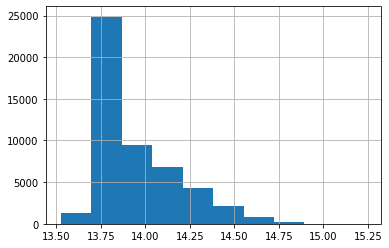

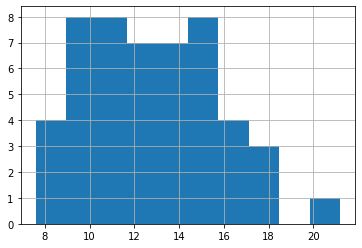

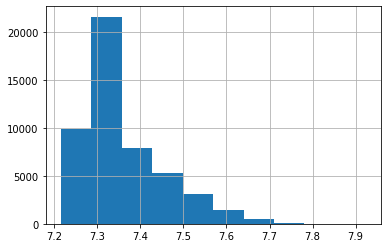

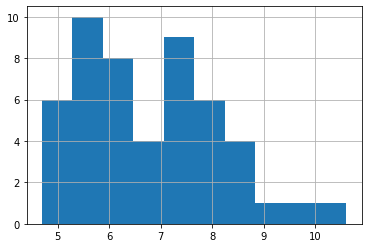

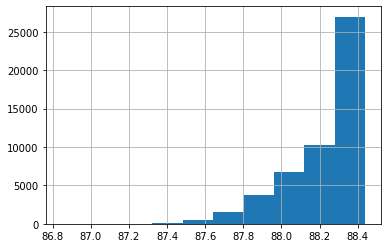

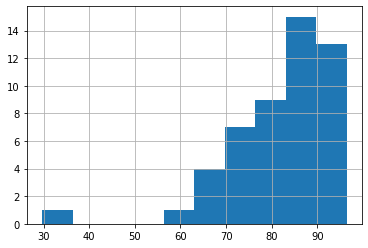

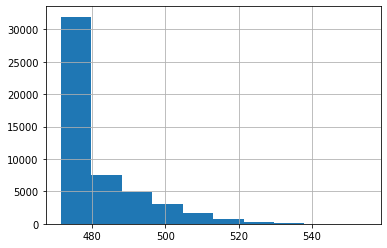

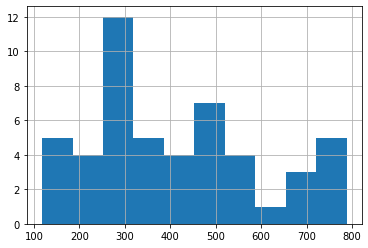

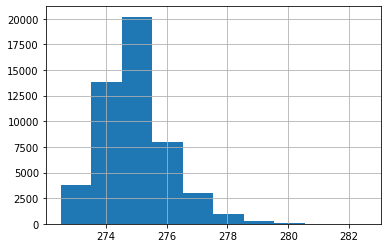

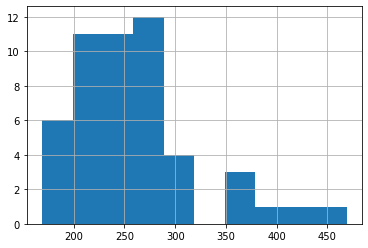

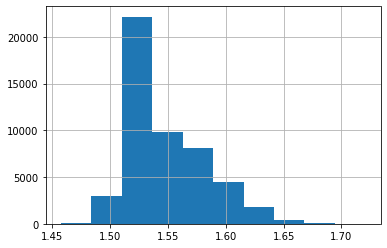

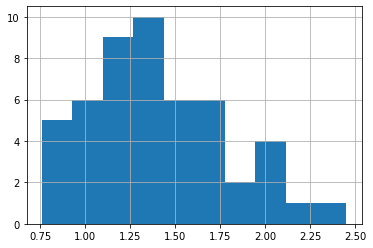

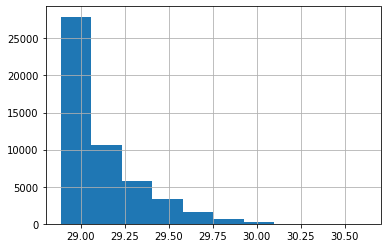

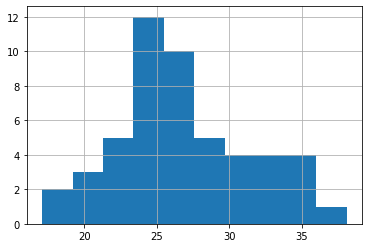

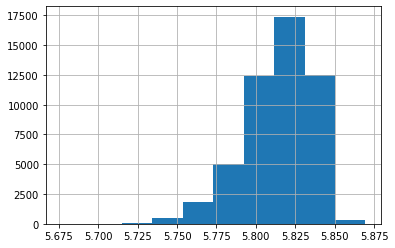

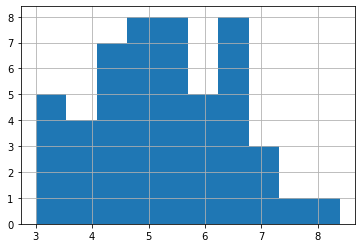

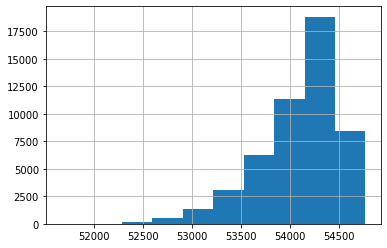

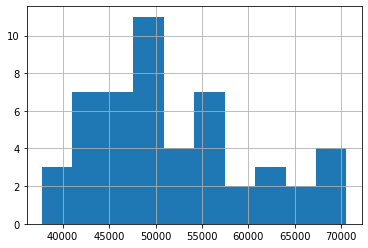

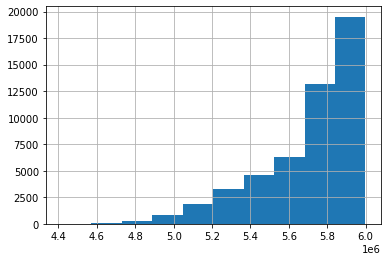

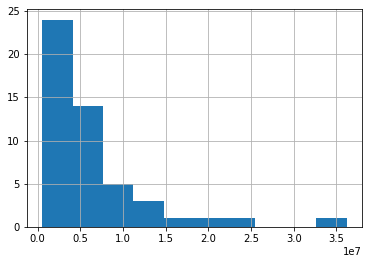

In [42]:

for r in range(0,10,1):
    pd.DataFrame(generated_df)[r].hist()
    plt.show()
    df.iloc[:,r].hist()
    plt.show()